# Loading Libraries 

In [43]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import shutil
import cv2  
import random
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
try:
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
except ImportError:
    from keras.preprocessing.image import ImageDataGenerator

# Loading Dataset

In [ ]:
# Extract dataset
#with zipfile.ZipFile("face-mask-12k-images-dataset.zip", "r") as zip_ref:
    #zip_ref.extractall("face_mask_data")

# Exploring Dataset

In [ ]:
#Check structure

dataset_path = r"D:\nti\face_mask_data"

print("Contents of dataset_path:", os.listdir(dataset_path))
for split in os.listdir(dataset_path):
    split_path = os.path.join(dataset_path, split)
    if os.path.isdir(split_path):
        print(f"\nInside {split}: {os.listdir(split_path)}")

Contents of dataset_path: ['Face Mask Dataset', 'Face_Mask_project', 'Face_Mask_Working']

Inside Face Mask Dataset: ['Test', 'Train', 'Validation', 'Validation - Shortcut.lnk']

Inside Face_Mask_project: ['Test', 'Train', 'Validation']

Inside Face_Mask_Working: ['Test', 'Train', 'Validation']


In [ ]:
# Count images per class

# Path to your dataset
dataset_path = r"D:\nti\face_mask_data\Face Mask Dataset"

#making lists for splits & labels
splits = ["Validation", "Test", "Train"]
labels = ["WithMask", "WithoutMask"]

# Counting
counts = {split: {label: 0 for label in labels} for split in splits}

for split in splits:
    for label in labels:
        folder = os.path.join(dataset_path, split, label)
        counts[split][label] = len(os.listdir(folder))

# Print counts
for split in splits:
    for label in labels:
        print(f"{split} / {label}: {counts[split][label]} images")

Validation / WithMask: 400 images
Validation / WithoutMask: 400 images
Test / WithMask: 483 images
Test / WithoutMask: 509 images
Train / WithMask: 5000 images
Train / WithoutMask: 5000 images


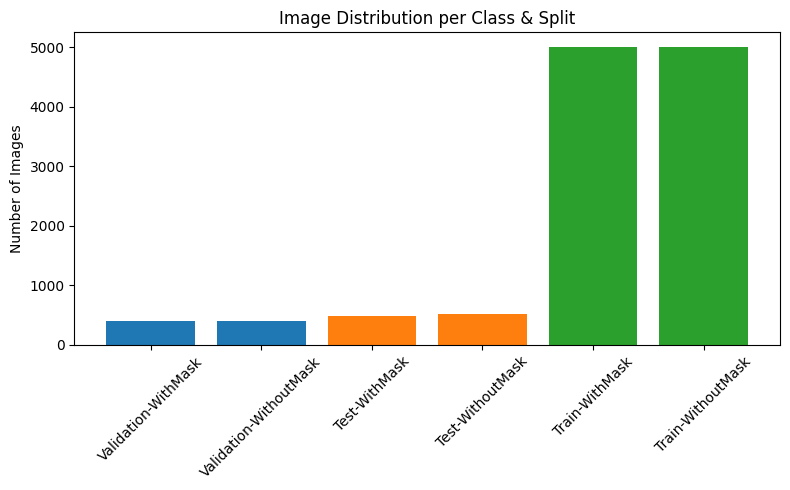

In [6]:
# Plot class distribution
plt.figure(figsize=(8, 5))       
for i, split in enumerate(splits):
    plt.bar(
        [f"{split}-{label}" for label in labels],
        [counts[split][label] for label in labels],
        label=split
    )

plt.ylabel("Number of Images")
plt.title("Image Distribution per Class & Split")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

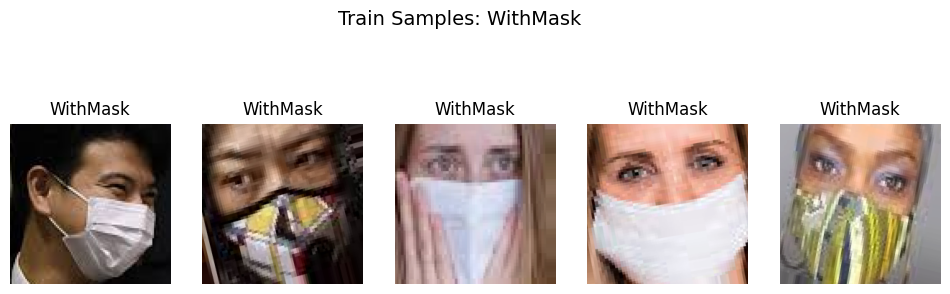

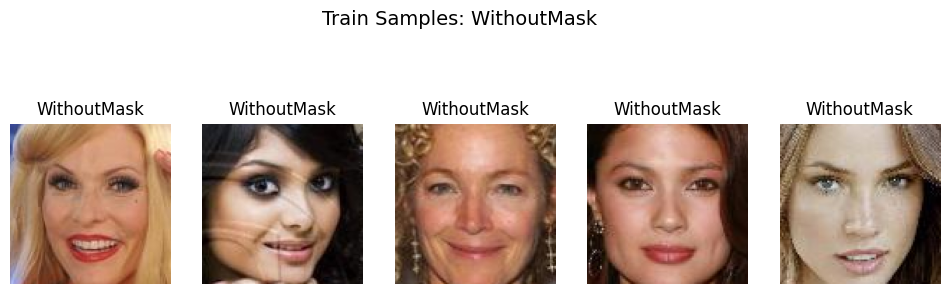

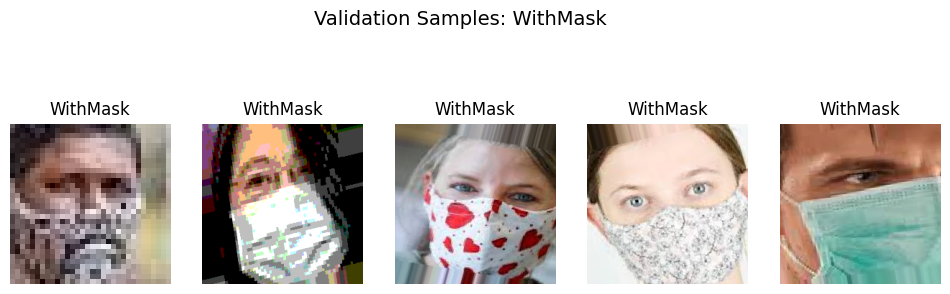

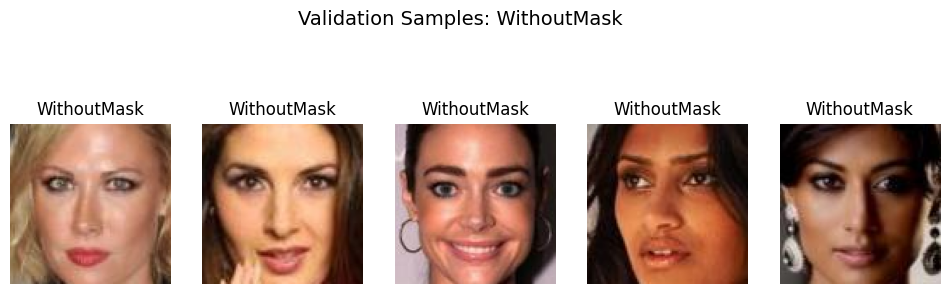

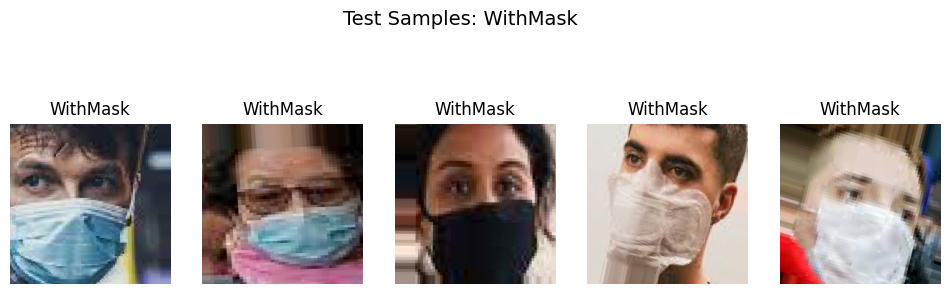

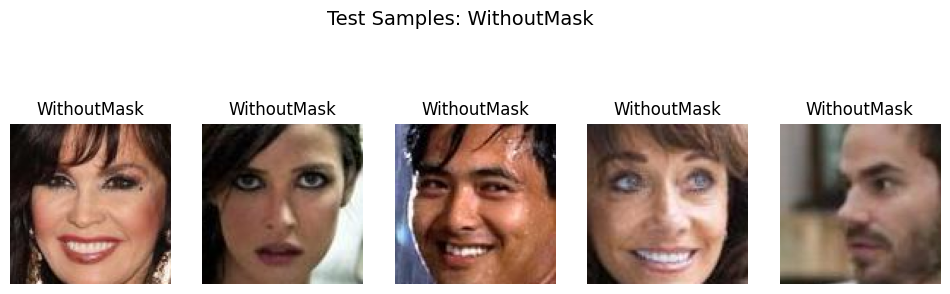

In [7]:
# Show sample images 
def show_samples(split, label, num_samples=5):
    folder = os.path.join(dataset_path, split, label)
    sample_files = random.sample(os.listdir(folder), num_samples)
    plt.figure(figsize=(12, 4))
    for i, file in enumerate(sample_files):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(label)
    plt.suptitle(f"{split} Samples: {label}", fontsize=14)
    plt.show()

# Show samples from each class in each folder
for label in labels:
    show_samples("Train", label)

for label in labels:
    show_samples("Validation", label)

for label in labels:
    show_samples("Test", label)

# Dataset Cleanup

**Deleting old copied dataset**

In [10]:
folder_path = r"D:\nti\face_mask_data\Face_Mask_Working"

if os.path.exists(folder_path):
    shutil.rmtree(folder_path)   # deletes folder + all files/subfolders inside
    print("Folder and contents deleted")
else:
    print("Folder not found")

Folder and contents deleted


**Copying original dataset**

In [11]:
original_path = r"D:\nti\face_mask_data\Face Mask Dataset"
working_path  = r"D:\nti\face_mask_data\Face_Mask_training"

# Copy the entire folder tree
shutil.copytree(original_path, working_path)
print(f"Copied dataset to: {working_path}")

Copied dataset to: D:\nti\face_mask_data\Face_Mask_training


**Searching for bad files**

In [12]:
dataset_path = r"D:\nti\face_mask_data\Face_Mask_training"
splits = ["Validation", "Test", "Train"]
labels = ["WithMask", "WithoutMask"]

bad_files = []

for split in splits:
    for label in labels:
        folder = os.path.join(dataset_path, split, label)
        for file in os.listdir(folder):
            file_path = os.path.join(folder, file)
            try:
                img = cv2.imread(file_path)
                if img is None or img.size == 0:
                    bad_files.append(file_path)
            except:
                bad_files.append(file_path)

print(f"Found {len(bad_files)} bad files.")
for bf in bad_files:
    print(bf)

Found 0 bad files.


**Searching for blurry images**

In [13]:
dataset_path = r"D:\nti\face_mask_data\Face_Mask_training"
splits = ["Validation", "Test", "Train"]
labels = ["WithMask", "WithoutMask"]

threshold = 100  # lower = stricter blur detection
blurry_files = []

for split in splits:
    for label in labels:
        folder = os.path.join(dataset_path, split, label)
        for file in os.listdir(folder):
            file_path = os.path.join(folder, file) 
            img = cv2.imread(file_path)  
            if img is None: 
                continue
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            variance = cv2.Laplacian(gray, cv2.CV_64F).var()
            if variance < threshold:
                blurry_files.append((file_path, variance))

print(f"Found {len(blurry_files)} blurry images.")
for f, var in blurry_files[:3]: 
    print(f"{f} -> Variance: {var}")

Found 361 blurry images.
D:\nti\face_mask_data\Face_Mask_training\Validation\WithMask\794.png -> Variance: 60.980714215537525
D:\nti\face_mask_data\Face_Mask_training\Validation\WithMask\Augmented_114_3364673.png -> Variance: 0.0
D:\nti\face_mask_data\Face_Mask_training\Validation\WithMask\Augmented_15_2242694.png -> Variance: 89.84903269914328


**Preprocessing step already made**

**Resizing image size will be made through loading the data**

# Training Model

In [54]:
# Data generators
# Training: with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

# Validation and Test: only rescaling (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load data from your 3 directories
train_generator = train_datagen.flow_from_directory(
    r"D:\nti\face_mask_data\Face_Mask_training\Train",  # Update this path
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_directory(
    r"D:\nti\face_mask_data\Face_Mask_training\validation",  # Update this path
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    r"D:\nti\face_mask_data\Face_Mask_training\test",  # Update this path
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Keep order for evaluation
)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [55]:
# Your model
input_layer = tf.keras.layers.Input(shape=(128, 128, 3))

model = tf.keras.models.Sequential([
    input_layer,
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

In [56]:
# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [57]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,337 (462.25 KB)

 Trainable params: 118,337 (462.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks for better training
callbacks = [
    # Stop training if validation loss doesn't improve
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate when stuck
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=0.0001,
        verbose=1
    ),
    
    # Save the best model
    tf.keras.callbacks.ModelCheckpoint(
        'best_mask_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

In [61]:
# Train the model with callbacks
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9704 - loss: 0.0841
Epoch 1: val_accuracy improved from None to 0.98125, saving model to best_mask_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 105s 336ms/step - accuracy: 0.9699 - loss: 0.0874 - val_accuracy: 0.9812 - val_loss: 0.0662 - learning_rate: 0.0010
Epoch 2/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9693 - loss: 0.0810
Epoch 2: val_accuracy did not improve from 0.98125
313/313 ━━━━━━━━━━━━━━━━━━━━ 108s 344ms/step - accuracy: 0.9718 - loss: 0.0784 - val_accuracy: 0.9775 - val_loss: 0.0538 - learning_rate: 0.0010
Epoch 3/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9737 - loss: 0.0828
Epoch 3: val_accuracy improved from 0.98125 to 0.98500, saving model to best_mask_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 107s 340ms/step - accuracy: 0.9734 - loss: 0.0827 - val_accuracy: 0.9850 - val_loss: 0.0458 - learning_rate: 0.0010
Epoch 4/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9706 - loss: 0.0843
Epoch 4: val_accuracy improved from 0.98500 to 0.99000, saving model to best_mask_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 105s 334ms/step - accuracy: 0.9703 - loss: 0.0825 - val_accuracy: 0.9900 - val_loss: 0.0305 - learning_rate: 0.0010
Epoch 5/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9694 - loss: 0.0797
Epoch 5: val_accuracy did not improve from 0.99000
313/313 ━━━━━━━━━━━━━━━━━━━━ 345s 1s/step - accuracy: 0.9740 - loss: 0.0716 - val_accuracy: 0.9812 - val_loss: 0.0534 - learning_rate: 0.0010
Epoch 6/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.9754 - loss: 0.0688
Epoch 6: val_accuracy did not improve from 0.99000
313/313 ━━━━━━━━━━━━━━━━━━━━ 104s 331ms/step - accuracy: 0.9752 - loss: 0.0731 - val_accuracy: 0.9875 - val_loss: 0.0283 - learning_rate: 0.0010
Epoch 7/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9797 - loss: 0.0638
Epoch 7: val_accuracy did not improve from 0.99000
313/313 ━━━━━━━━━━━━━━━━━━━━ 370s 1s/step - accuracy: 0.9779 - loss: 0.0649 - val_accuracy: 0.9862 - val_loss: 0.0339 - learning_rate: 0.0010
Epoch 8/25
313/

313/313 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - accuracy: 0.9721 - loss: 0.0772 - val_accuracy: 0.9912 - val_loss: 0.0252 - learning_rate: 0.0010
Epoch 10/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9799 - loss: 0.0583
Epoch 10: val_accuracy did not improve from 0.99125
313/313 ━━━━━━━━━━━━━━━━━━━━ 113s 362ms/step - accuracy: 0.9783 - loss: 0.0595 - val_accuracy: 0.9900 - val_loss: 0.0264 - learning_rate: 0.0010
Epoch 11/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9738 - loss: 0.0657
Epoch 11: val_accuracy did not improve from 0.99125
313/313 ━━━━━━━━━━━━━━━━━━━━ 108s 344ms/step - accuracy: 0.9741 - loss: 0.0680 - val_accuracy: 0.9850 - val_loss: 0.0347 - learning_rate: 0.0010
Epoch 12/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9732 - loss: 0.0729
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 12: val_accuracy did not improve from 0.99125
313/313 ━━━━━━━━━━━━━━━━━━━━ 425s 1s/step - accuracy: 0.9776 - loss: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 98s 314ms/step - accuracy: 0.9845 - loss: 0.0407 - val_accuracy: 0.9937 - val_loss: 0.0191 - learning_rate: 2.0000e-04
Epoch 15/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9865 - loss: 0.0358
Epoch 15: val_accuracy did not improve from 0.99375
313/313 ━━━━━━━━━━━━━━━━━━━━ 91s 289ms/step - accuracy: 0.9873 - loss: 0.0355 - val_accuracy: 0.9937 - val_loss: 0.0201 - learning_rate: 2.0000e-04
Epoch 16/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.9873 - loss: 0.0379
Epoch 16: val_accuracy did not improve from 0.99375
313/313 ━━━━━━━━━━━━━━━━━━━━ 89s 283ms/step - accuracy: 0.9861 - loss: 0.0399 - val_accuracy: 0.9925 - val_loss: 0.0168 - learning_rate: 2.0000e-04
Epoch 17/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9885 - loss: 0.0362
Epoch 17: val_accuracy did not improve from 0.99375
313/313 ━━━━━━━━━━━━━━━━━━━━ 114s 365ms/step - accuracy: 0.9873 - loss: 0.0384 - val_accuracy: 0.9925 - val_loss: 0.0170 - learning_r

In [62]:
# Evaluate on test data
print("Evaluating on test data...")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Evaluating on test data...
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 623ms/step - accuracy: 0.9919 - loss: 0.0232
Test Accuracy: 0.9919
Test Loss: 0.0232


In [63]:
# Get detailed predictions
test_predictions = model.predict(test_generator)
test_pred_binary = (test_predictions > 0.5).astype(int)
test_labels = test_generator.classes

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step


In [64]:
# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_pred_binary, 
                          target_names=['No Mask', 'Mask']))

print("\nConfusion Matrix:")
print(confusion_matrix(test_labels, test_pred_binary))


Classification Report:
              precision    recall  f1-score   support

     No Mask       0.99      1.00      0.99       483
        Mask       1.00      0.99      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992


Confusion Matrix:
[[482   1]
 [  7 502]]


In [77]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_mask(img_path, model, class_names):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    pred = model.predict(img_array)[0][0]

    if pred < 0.4:
       label = "WithMask"
    else:
       label = "WithoutMask"


# Run on all images inside the test folder
test_folder = r"D:\nti\face_mask_data\Face_Mask_training\test"

for fname in os.listdir(test_folder):
    if fname.lower().endswith((".png", ".jpg", ".jpeg")):  # only images
        img_path = os.path.join(test_folder, fname)
        label, prob = predict_mask(img_path, model, ["WithMask", "WithoutMask"])
        print(f"{fname} → Prediction: {label} (prob={prob:.4f})")

In [74]:
# Save entire model (architecture + weights + optimizer state)
model.save("face_detect_model.h5")

In [66]:
#  Function to predict single images
def predict_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))  # Changed to 128
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array /= 255.0
    
    prediction = model.predict(img_array)[0][0]
    
    if prediction > 0.5:
        return f"Mask detected (confidence: {prediction:.2f})"
    else:
        return f"No mask detected (confidence: {1-prediction:.2f})"

In [68]:
import os

# Replace with your dataset root
data_dir = r"D:\nti\face_mask_data\Face_Mask_training\Train"

# List folders inside
class_names = sorted(os.listdir(data_dir))
print("Detected classes (alphabetical order):", class_names)

# Optional: peek inside each folder
for cls in class_names:
    folder_path = os.path.join(data_dir, cls)
    samples = os.listdir(folder_path)[:5]  # first 5 files
    print(f"\nClass '{cls}' has {len(os.listdir(folder_path))} images")
    print("Example files:", samples)


Detected classes (alphabetical order): ['WithMask', 'WithoutMask']

Class 'WithMask' has 5000 images
Example files: ['10.png', '100.png', '1004.png', '1005.png', '1006.png']

Class 'WithoutMask' has 5000 images
Example files: ['10.png', '100.png', '1004.png', '1005.png', '1006.png']
